# CH6. 통계적 머신러닝(statistical machine learning)

## 6.1 k-최근접 이웃(KNN, k-nearest neighbors)
1. 특징들이 가자 유사한(즉, 예측변수들이 유사한) k개 레코드를 찾는다.
2. 분류: 이 유사한 레코드들 중에 다수가 속한 클래스가 무엇인지 찾은 후, 새로운 레코드를 그 클래스에 할당
3. 예측(<b>KNN 회귀, KNN regression</b>라고도 함): 유사한 레코드들의 평균을 찾아서 새로운 레코드에 대한 예측값으로 사용한다.

============================================================================================================
###### 용어정리
 - 이웃(neighbor): 예측변수에서 값들이 유사한 레코드
 - 거리지표(distance metric): 각 레코드 사이가 얼마나 멀리 떨어져 있는지를 나타내는 단일 값
 - 표준화(standardization): 평균을 뺀 후에 표준편차로 나누는 일(유의어: 정규화)
 - z 점수(z-score): 표준화를 통해 얻은 값
 - k: 최근접 이웃을 계산하는 데 사용되는 이웃의 개수

============================================================================================================

 - 특징들이 어떤 척도에 존재하는지, 가까운 정도를 어떻게 측정할 것인지, k를 어떻게 설정할 것인지에 따라 예측 결과가 달라진다.
 - 모든 예측변수들은 수치형이어야 한다.

*k: 예측하고자 하는 값와 근접한 k개 레코드를 활용한다는 것??*

### 6.1.1 예제: 대출 연체 예측

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import random
from collections import defaultdict
from itertools import product # 두 하이퍼파라미터의 가능한 모든 조합을 만들기 위해 파이썬 표준 라이브러리 활용

from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


In [2]:
loan200 = pd.read_csv('C:/data/stats_for_ds/loan200.csv') ;loan200

,outcome,payment_inc_ratio,dti
0,target,9.00000,22.50
1,default,5.46933,21.33
2,paid off,6.90294,8.97
3,paid off,11.14800,1.83
4,default,3.72120,10.81
...,...,...,...
196,default,11.66300,26.09
197,default,2.97641,16.41
198,default,1.96846,19.98
199,paid off,9.64200,20.17


In [3]:
from sklearn.neighbors import KNeighborsClassifier

In [4]:
predictors = ['payment_inc_ratio', 'dti'] # 각각 소득에 대한 대출 상환 비율, 소득애 대한 부채(모기지 제외) 비율
outcome = 'outcome'

newloan = loan200.loc[0:0, predictors] 
X = loan200.loc[1:, predictors]
y = loan200.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
knn.predict(newloan)
print(knn.predict_proba(newloan))

[[0.45 0.55]]


In [5]:
nbrs = knn.kneighbors(newloan)
maxDistance = np.max(nbrs[0][0])

In [6]:
from matplotlib.patches import Ellipse

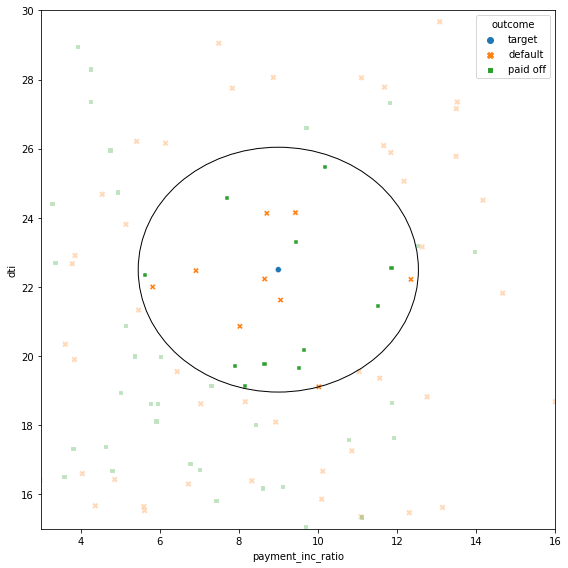

In [7]:
# [그림 6-2] 두 변수를 이용한 KNN의 대출 연체 예측
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', data=loan200, alpha=0.3, ax=ax)
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', 
                data=pd.concat([loan200.loc[0:0, :], loan200.loc[nbrs[1][0] + 1,:]]), 
                ax=ax, legend=False)
ellipse = Ellipse(xy=newloan.values[0], 
                  width=2 * maxDistance, height=2 * maxDistance,
                  edgecolor='black', fc='None', lw=1)
ax.add_patch(ellipse)
ax.set_xlim(3, 16)
ax.set_ylim(15, 30)

plt.tight_layout()
plt.show()

##### NOTE_ 
 - 분류 문제에서 KNN의 결과는 보통 이진형이지만 때로는 0과 1 사이의 확률(경향)을 결과로 줄 수 있다.
 - k개 가장 가까운 점들이 속한 클래스의 비율을 통해 확률을 정할 수 있다.
 - 확률 점수를 통해 간단한 다수결 투표 결과와는 다른 분류 규칙을 만들 수 있다.

### 6.1.2 거리 지표
 - 유사성, similarity (근접성, nearness)은 <b>거리지표</b>를 통해 결정된다.

1. <b>유클리드 거리, Euclidean distance</b>
 - 두 점 사이의 직선 거리
 - 계산상 이점이 있다.
 
 $$ \sqrt {(x_1 - u_1)^2 + (x_2 - u_2)^2 + ... + (x_p - u_p)^2} $$
 
2. <b>맨해튼 거리, Manhattan distance</b>
 - 한 번에 대각선이 아닌 한 축 방향으로만 움직일 수 있다고 할 때(도심지에서 직사각형 건물들 사이를 이동한다고 할 때_, 두 점 사이의 거리
 - 점과 점 사이의 이동 시간으로 근접성ㅇ르 따질 때 좋은 지표
 
 $$ |x_1 - u_1| + |x_2 - u_2| + ... + |x_P - u_p| $$ 
 
3. 기타 지표
 - (1) <b>마할라노비스 거리, Mahalanobis distance </b>
    - 두 변수 간 상관관계 활용
    - 계산에 공분산행렬을 사용하기 때문에 많은 계산이 필요하고 복잡성이 증가하는 단점이 있음.

### 6.1.3 원-핫 인코더
 - 요인변수를 수치형으로 변환하는 방법
 - n개 범주를 갖는 요인변수의 각 범주를 이진 가변수로 변환하여 n개 변수 생성

###### NOTE_
선형 회귀나 로지스틱 회귀에서 원-핫 인코딩은 다중공선성과 관련된 문제를 일으킨다. 이런 경우 한 가변수를 생략하는 방법이 있다.
BUT, 이 책에서 다루는 KNN이나 다른 방법에서는 이것이 문제가 되지 않는다.

### 6.1.4 표준화(정규화, z 점수)

*책에서는 표준화와 정규화를 같은 것으로 다루지만, 차이가 있음*
*책에서 다루는 것은 표준화(Standardization)이고, 정규화(Normalization)은 아래에서 따로 다루도록 함*

1.<b>표준화(Standardization)</b>
 - 정규분포의 표준화 공식으로, 어떤 특성의 값들이 정규분포를 따른다고 가정하고 값들을 평균이 0, 표준편차가 1을 갖도록 변환해주는 것
 - 변환된 결과를 일반적으로 <b>z score</b>라고 부름
 $$ z = \frac {x-\bar{x}} {s} $$
 

2. <b>정규화(Normalization)</b>
 - 다음과 같은 공식을 사용해서 특성 값의 범위를 [0, 1]로 옮기는 것
 
 $$ X^\prime = \frac {X-X_{min}} {X_{max}-X_{min}} $$



- 위 두 가지 방법을 모두 사용해보고 어느것이 더 나은지 비교하여 방법 선택

*참고자료*
*https://bskyvision.com/849*

In [8]:
loan_data = pd.read_csv('C:/data/stats_for_ds/loan_data.csv') ;loan_data

,Unnamed: 0,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,...,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,...,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,...,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,...,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,...,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,...,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45337,45338,Fully Paid,8000,36 months,72000,18.97,4.57850,9725,58.2,credit_card,...,1,0,9,4.2,paid off,8,credit_card,RENT,> 1 Year,0.35
45338,45339,Fully Paid,2000,36 months,25200,13.24,3.20333,4925,40.7,wedding,...,0,1,13,4.2,paid off,3,other,MORTGAGE,> 1 Year,0.50
45339,45340,Fully Paid,4375,36 months,20000,7.95,9.98460,6574,73.0,debt_consolidation,...,1,1,8,2.4,paid off,1,debt_consolidation,MORTGAGE,> 1 Year,0.55
45340,45341,Fully Paid,8000,36 months,48000,26.91,6.45250,10303,32.4,debt_consolidation,...,1,1,10,5.2,paid off,1,debt_consolidation,MORTGAGE,> 1 Year,0.65


In [9]:
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)
loan_data

,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,home_ownership,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,2500,60 months,30000,1.00,2.39320,1687,9.4,car,RENT,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,OWN,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,5375,60 months,15000,18.08,9.71600,9279,36.5,other,RENT,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,RENT,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,10000,36 months,100000,7.06,3.90888,11997,55.5,other,RENT,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45337,8000,36 months,72000,18.97,4.57850,9725,58.2,credit_card,RENT,1,0,9,4.2,paid off,8,credit_card,RENT,> 1 Year,0.35
45338,2000,36 months,25200,13.24,3.20333,4925,40.7,wedding,MORTGAGE,0,1,13,4.2,paid off,3,other,MORTGAGE,> 1 Year,0.50
45339,4375,36 months,20000,7.95,9.98460,6574,73.0,debt_consolidation,MORTGAGE,1,1,8,2.4,paid off,1,debt_consolidation,MORTGAGE,> 1 Year,0.55
45340,8000,36 months,48000,26.91,6.45250,10303,32.4,debt_consolidation,MORTGAGE,1,1,10,5.2,paid off,1,debt_consolidation,MORTGAGE,> 1 Year,0.65


In [10]:
# 스케일링 하지 않고 fit KNN
predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

newloan = loan_data.loc[0:0, predictors]
print(newloan)
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

   payment_inc_ratio  dti  revol_bal  revol_util
0             2.3932  1.0       1687         9.4


KNeighborsClassifier()

In [11]:
nbrs = knn.kneighbors(newloan)
print(X.iloc[nbrs[1][0], :])

       payment_inc_ratio   dti  revol_bal  revol_util
35536            1.47212  1.46       1686        10.0
33651            3.38178  6.37       1688         8.4
25863            2.36303  1.39       1691         3.5
42953            1.28160  7.14       1684         3.9
43599            4.12244  8.98       1684         7.2


In [12]:
from sklearn import preprocessing

In [13]:
# 스케일링 후 fit KNN
newloan = loan_data.loc[0:0, predictors]
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

scaler = preprocessing.StandardScaler()
scaler.fit(X * 1.0)

X_std = scaler.transform(X * 1.0)
newloan_std = scaler.transform(newloan * 1.0)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std, y)

nbrs = knn.kneighbors(newloan_std)
print(X.iloc[nbrs[1][0], :])

       payment_inc_ratio   dti  revol_bal  revol_util
2080             2.61091  1.03       1218         9.7
1438             2.34343  0.51        278         9.9
30215            2.71200  1.34       1075         8.5
28542            2.39760  0.74       2917         7.4
44737            2.34309  1.37        488         7.2


### 6.1.5 k 선택하기
 - k가 너무 작으면 Overfitting 문제 발생
 - k가 너무 크면 Overboosting(과대 평탄화) 문제 발생
 
 <br> 
 
 - 최적의 k값 위해 지표 활용
  - 홀드아웃 데이터 또는 타당성 검사를 위해 따로 뗴어놓은 데이터에서 정확도 측정하여 k값 결정에 사용
 
 <br> 
 
 - 노이즈가 거의 없고 아주 잘 구조화된 데이터의 경우 k값이 작을수록 잘 동작
 - 노이즈가 많은 경우 k가 클수록 좋다.
 
 <br> 
 
 - 보통 k를 1과 20 사이에 놓는다.
 - 동률이 나오는 경우를 막기 위해 보통은 홀수를 사용한다.


###### NOTE_ 편향-분산 트레이드오프(bias-variance tradeoff)
 - 과대 평탄화(오버부스팅)와 과대적합화(오버피팅) 사이의 이율배반 관계를 의미
 - 편향: 모델이 실제 세계를 정확히 표현하지 못하기 때문에 발생하는 모델링 오차를 의미
 - 유연한 모델에서 오버피팅이 발생했다면 분산이 증가했음을 의미
 - 트레이드오프를 다루기 위해 일반적으로 <b>교차타당성검사</b> 방법 활용


### 6.1.6 KNN을 통한 피처 엔지니어링
- KNN은 구현이 간단하고 직관적이지만, 성능 면에서는 경쟁력이 떨어짐
- BUT, 실용적인 측면에서 다른 분류 방법들의 특정 단계에 사용할 수 있게 모델에 '지역적 정보, local knowledge'를 추가하기 위해 활용 가능

 1. KNN은 데이터에 기반하여 분류 결과(클래스에 속할 확률)를 얻는다.
 2. 이 결과는 해당 레코드에 새로운 특징(피처)으로 추가된다. 이 결과를 다른 분류 방법에 사용한다. 원래 예측변수들(X)을 두 번씩 사용하는 셈이 된다.
 
 <br>
 
- *!다중공선성 문제를 야기시키는건 아닐까?*
 - 문제가 되지 않는다.
 - 위 2단계에서 얻은 정보는 소수의 근접한 레코드들로부터 얻은 매우 지엽적인 정보로, 새로 얻은 정보는 불필요하거나 중복성이 있지 않다.

In [14]:
loan_data = pd.read_csv('C:/data/stats_for_ds/loan_data.csv') ;loan_data

loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)

loan_data

,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,home_ownership,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,2500,60 months,30000,1.00,2.39320,1687,9.4,car,RENT,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,OWN,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,5375,60 months,15000,18.08,9.71600,9279,36.5,other,RENT,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,RENT,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,10000,36 months,100000,7.06,3.90888,11997,55.5,other,RENT,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45337,8000,36 months,72000,18.97,4.57850,9725,58.2,credit_card,RENT,1,0,9,4.2,paid off,8,credit_card,RENT,> 1 Year,0.35
45338,2000,36 months,25200,13.24,3.20333,4925,40.7,wedding,MORTGAGE,0,1,13,4.2,paid off,3,other,MORTGAGE,> 1 Year,0.50
45339,4375,36 months,20000,7.95,9.98460,6574,73.0,debt_consolidation,MORTGAGE,1,1,8,2.4,paid off,1,debt_consolidation,MORTGAGE,> 1 Year,0.55
45340,8000,36 months,48000,26.91,6.45250,10303,32.4,debt_consolidation,MORTGAGE,1,1,10,5.2,paid off,1,debt_consolidation,MORTGAGE,> 1 Year,0.65


In [15]:
predictors = ['dti', 'revol_bal', 'revol_util', 'open_acc', 
              'delinq_2yrs_zero', 'pub_rec_zero']
outcome = 'outcome'

X = loan_data[predictors]
y = loan_data[outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=20)

In [16]:
import random

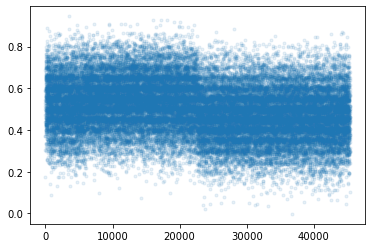

In [17]:
plt.scatter(range(len(X)), [bs + random.gauss(0, 0.015) for bs in knn.predict_proba(X)[:,0]], 
            alpha=0.1, marker='.')

In [18]:
knn.predict_proba(X)[:, 0]

loan_data['borrower_score'] = knn.predict_proba(X)[:, 0]
print(loan_data['borrower_score'].describe())

count    45342.000000
mean         0.501104
std          0.128734
min          0.000000
25%          0.400000
50%          0.500000
75%          0.600000
max          0.950000
Name: borrower_score, dtype: float64


###### 주요개념
 - $k$-최근접 이웃(KNN) 방법이란 유사한 레코드들이 속한 클래스로 레코드를 분류하는 방법
 - 유사성(거리)은 유클리드 거리나 다른 관련 지표들을 이용해 결정
 - 가장 가까운 이웃 데이터의 개수를 의미하는 $k$는 학습 데이터에서 얼마나 좋은 성능을 보이는지를 가지고 결정
 - 일반적으로 예측변수들을 표준화(스케일링)한다. 이를 통해 스케일이 큰 변수들의 영향력이 너무 커지지 않도록 한다.
 - 예측 모델링의 첫 단계에서 종종 KNN을 사용한다. 이렇게 얻은 값을 다시 데이터에 하나의 <b>예측변수</b>로 추가해서 두 번째 단계의 (KNN이 아닌) 모델링을 위해 사용한다.

## 6.2 트리모델

- 회귀 및 분석트리(CART, classification and regression tree) = 의사결정트리(decition tree) = 트리(tree)

=======================================================================================================
###### 용어정리
 - 재귀분할(recursive partitioning): 마지막 분할 영역에 해당하는 출력이 최대한 비슷한(homogeneous) 결과를 보이도록 데이터를 반복적으로 분할하는 것
 - 분할값(split value): 분할값을 기준으로 예측변수를 그 값보다 작은 영역과 큰 영역으로 나눈다.
 - 마디(노드, node): 의사 결정 트리와 같은 가지치기 형태로 구성된 규칙들의 집합에서, 노드는 분할 규칙의 시각적인 표시라고 할 수 있다.
 - 잎(leaf): if-then 규칙의 가장 마지막 부분, 혹은 트리의 마지막 가지(Branch) 부분을 의미한다. 트리 모델에서 잎 노드는 어떤 레코드에 적용할 최종적인 분류 규칙을 의미한다.
 - 손실(loss): 분류하는 과정에서 발생하는 오분류의 수. 손실이 클수록 불순도가 높다고 할 수 있다.
 - 불순도(impurity): 데이터를 분할한 집단에서 서로 다른 클래스의 데이터가 얼마나 섞여 있는지를 나타낸다. 더 많이 섞여 있을수록 불순도가 높다고 할 수 있다.(유의어: 이질성, heterogeneity, 반의어: 동질성,homogeneity, 순도)
 - 가지치기(pruning): 학습이 끝난 트리 모델에서 오버피팅을 줄이기 위해 가지들을 하나씩 잘라내는 과정
 
=======================================================================================================

### 6.2.1 간단한 예제

In [19]:
loan3000 = pd.read_csv('C:/data/stats_for_ds/loan3000.csv') ;loan3000

,Unnamed: 0,outcome,purpose_,dti,borrower_score,payment_inc_ratio
0,32109,paid off,debt_consolidation,21.23,0.40,5.11135
1,16982,default,credit_card,15.49,0.40,5.43165
2,25335,paid off,debt_consolidation,27.30,0.70,9.23003
3,34580,paid off,major_purchase,21.11,0.40,2.33482
4,14424,default,debt_consolidation,16.46,0.45,12.10320
...,...,...,...,...,...,...
2995,36589,paid off,debt_consolidation,13.30,0.50,18.36620
2996,43889,paid off,other,6.09,0.60,1.80421
2997,7219,default,debt_consolidation,16.13,0.20,15.42180
2998,8987,default,debt_consolidation,18.39,0.45,8.92335


In [20]:
from sklearn.tree import DecisionTreeClassifier
from dmba import plotDecisionTree, textDecisionTree

In [21]:
pip install pydotplus

Note: you may need to restart the kernel to use updated packages.


In [22]:
import os 
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [23]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy',
                                   min_impurity_decrease=0.003)
loan_tree.fit(X, y)
plotDecisionTree(loan_tree, feature_names=predictors, class_names=loan_tree.classes_)


InvocationException: GraphViz's executables not found

In [24]:
print(textDecisionTree(loan_tree))

node=0 test node: go to node 1 if 0 <= 0.5750000178813934 else to node 6
  node=1 test node: go to node 2 if 0 <= 0.32500000298023224 else to node 3
    node=2 leaf node: [[0.785, 0.215]]
    node=3 test node: go to node 4 if 1 <= 10.42264986038208 else to node 5
      node=4 leaf node: [[0.488, 0.512]]
      node=5 leaf node: [[0.613, 0.387]]
  node=6 test node: go to node 7 if 1 <= 9.19082498550415 else to node 10
    node=7 test node: go to node 8 if 0 <= 0.7249999940395355 else to node 9
      node=8 leaf node: [[0.247, 0.753]]
      node=9 leaf node: [[0.073, 0.927]]
    node=10 leaf node: [[0.457, 0.543]]


### 6.2.2 재귀 분할 알고리즘

<b>응답변수 $Y$와 $P$개의 예측변수 집합 $X_j(j=1, 2, ..., P)$가 있다고 가정하자. 어떤 파티션(분할영역) A에 대해, A를 두 개의 하위 분할 영역으로 나누기 위한 가장 좋은 재귀적 분할 방법을 찾아야 한다.</b>

1. 각 예측변수 $X_j$에 대해,
 a. $X_j$에 해당하는 각 변수 $s_j$에 대해
   i. $A$에 해당하는 모든 레코드를 $X_j < s_j$인 부분과 나머지 $X_j >= s_j$인 부분으로 나눈다.
   ii. $A$의 각 하위 분할 영역 안에 해당 클래스의 동질성을 측정한다.
 b. 하위 분할 영역 내에서의 클래스 동질성이 가장 큰 $s_j$ 값을 선택한다.
2. 클래스 동질성이 가장 큰 변수 $X_j$와 $s_j$의 값을 선택한다.

이제 알고리즘의 <b>재귀 부분</b>이 나온다.

1. 전체 데이터를 가지고 $A$를 초기화한다.
2. $A$를 두 부분 $A_1$과 $A_2$로 나누기 위해 분할 알고리즘을 적용한다.
3. $A_1$과 $A_2$ 각각에서 2번 과정을 반복한다.
4. 분할을 해도 더는 하위 분할 영역의 동질성이 개선되지 않을 정도로 충분히 분할을 진행했을 때, 알고리즘을 종료한다.

- 각 영역은 해당 여영ㄱ에 속한 응답변수들의 다수결 결과에 따라 0 또는 1로 예측 결과를 결정한다.

###### NOTE_
0 또는 1의 이진 결과 외에, 트리 모델은 하위 분할 영역에 존재하는 0과 1의 개수에 따라 확률 값을 구할 수도 있다. 간단히 분할 영역에 속하는 0 혹은 1의 개수를 전체 데이터의 개수로 나누면 구할 수 있다.

$$ P(Y=1) = \frac {파티션 내 1의 개수} {파티션의 크기} $$

이렇게 얻은 $P(Y=1)$을 통해 이진 결정을 할 수 있다. (예를들어 $Y(P=1)>0.5인 경우 1로 예측)

### 6.2.3 동질성과 불순도 측정하기
 - 각 분할 영역에 대한 동질성, 즉 <b>클래스 순도, class purity</b> 측정 방법 필요
  1. $p$를 통한 정확도 표시: 해당 파티션 내 오분류된 레코드 비율 (불순도 측정에 썩 좋지 않음)
  2. <b>지니 불순도, Gini impurity</b>: $I(A) = p(1-p)$
  3. <b>엔트로피, entropy</b>: $I(A) = -p\log_2{(p)} - (1-p)\log_2{(1-p)}$
  
###### CAUTION_ 지니계수
 - 지니불순도 != 지니계수
 - <b>지니 계수, Gini coefficient</b>: 지니불순도와 개념적으로 비슷하지만 지니 계수는 이진 분류 문제로 한정됨

### 6.2.4 트리 형성 중지하기
 - 트리가 커질수록(깊어질수록) 오버피팅의 가능성이 늘어난다. (학습데이터의 노이즈까지 학습한 결과)
 
 - 분할을 멈추는 방법
  1. 분할을 통해 얻어지는 하위 영역 또는 말단 잎의 크기가 너무 작다면 분할을 멈춘다.
  2. 새로운 분할 영역이 '유의미'한 정도로 불순도를 줄이지 않는다면 굳이 분할하지 않는다.
  
  
 - 파이썬에서 트리 복잡도 제어 방법 
  - sklearn.DecisionTree에서 복잡도 제어를 위한 인수는 'cpp_alpha'
  - GridSearchCV로 최적의 값을 찾을 수 있음
  
  - 트리 크기를 제어하는 파라미터: max_depth, min_sample_split 등등. 
  - sklearn.GridSearchCV는 모든 조합에 대한 완전 검색과 교차 검증을 결합한 편리한 방법

### 6.2.5 연속값 예측하기 (회귀)
 - 불순도 측정 방법: 하귀 분할 영역에서 편차제곱합
 - 예측 성능 평가 방법: RMSE(제곱근평균제곱오차)

### 6.2.6 트리 활용하기 
 - 블랙박스 모델이 아니라서 비전공자/다른 조직원에게 설명하기 좋음 (시각화 가능)
 
###### 주요개념
 - 의사결정트리는 결과를 분류하거나 예측하기 위한 일련의 규칙들을 생성한다.
 - 이 규칙들은 데이터를 하위 영역으로 연속적으로 분할하는 것과 관련이 있다.
 - 각 분할 혹은 분기는 어떤 한 예측변수 값을 기준으로 데이터를 위아래 두 부분으로 나누는 것이다.
 - 각 단계마다, 트리 알고리즘은 결과의 불순도를 최소화하는 쪽으로 영역 분할을 진행한다.
 - 더 이상 분할이 불가능할 때, 트리가 완전히 자랐다고 볼 수 있으며 각 말단 노드 혹은 잎 노드에 해당하는 레코드들은 단일 클래스에 속한다. 새로운 데이터는 이 규칙 경로를 따라 해당 클래스로 할당된다.

## 6.3 배깅과 랜덤 포레스트

==============================================================================================================
###### 용어정리
- 앙상블(ensemble): 여러 모델의 집합을 이용해서 하나의 예측을 이끌어내는 방식(유의어: 모델평균화(model averaging))
- 배깅(bagging): 데이터를 부트스트래핑해서 여러 모델을 만드는 일반적인 방법(유의어: 부트스트랩 종합(bootstrap aggregation))
- 랜덤 포레스트(random forest): 의사 결정 트리 모델에 깁나을 둔 배깅 추정 모델(유의어: 배깅 의사 결정 트리)
- 변수 중요도(variable importance): 모델 성능에 미치는 예측변수의 중요도

==============================================================================================================

앙상블 방법의 가장 간단한 버전
 1. 주어진 데이터에 대해 예측 모델을 만들고 예측 결과 기록
 2. 같은 데이터에 대해 여러 모델을 만들고 결과 기록
 3. 각 레코드에 대해 예측된 결과들의 평균(또는 가중평균, 다수결 투표) 산출

### 6.3.1 배깅
- bagging(bootstrap aggregating): 매번 부트슽트립 재표본에 대해 새로운 모델을 만듦

1. 만들 모델의 개수 $M$과 모델을 만드는 데 사용할 레코드의 개수 $n(n<N)$의 값 초기화. 반복 변수 $m=1$로 둔다.
2. 훈련 데이터로부터 복원추출 방법으로 $n$개의 부분 데이터 $Y_m, X_m$을 부트스트랩 재표본 추출
3. 의사 결정 규칙 $\hat{f}_m(X)$를 얻기 위해, $Y_m$과 $X_m$을 이용ㅇ해 모델 학습
4. $m=m+1$로 모델 개수 늘리고, $m<M$이면 다시 2단계로 간다.

$\hat{f)_m$이 $Y=1$인 경우의 확률을 예측한다고 했을 때, 배깅 추정치는 다음과 같이 정의할 수 있다.
$$\hat{f} = \frac{1}{M}(\hat{f}_1(X)+\hat{f}_2(X)+...+\hat{f}_M(X))$$

### 6.3.2 랜덤 포레스트
 - 의사결정트리 모델에 한가지 중요한 요소가 추가된 배깅 방법을 적용한 모델
 - 랜덤포레스트에서는 알고리즘의 각 단계마다, 고를 수 있는 변수가 <b>랜덤하게 결정된 전체 변수들의 부분집합</b>에 한정된다.
 
1. 전체 데이터로부터 부트스트랩 샘플링(복원추출)
2. 첫 분할을 위해 비복원 임의표본추출로 $p(p<P)$개의 변수 샘플링
3. 샘플링된 변수 $X_{j(1)}, X_{j(2)}, ..., X_{j(p)}$에 대해 분할 알고리즘 적용 <br>
 a. $X_{j(k)}$의 각 변수 $s_{j(k)}$에 대해 <br>
   i. 파티션 $A$에 있는 레코드들을 $X_{j(k)} < s_{j(k)}$인 하위 영역과 $X_{j(k)}>=s_{j(k)}$인 하위 영역으로 나눔 <br>
   ii. $A$의 각 하위 영역 내부의 클래스의 동질성 측정 <br>
 b. 분할 영역 내부의 클래스의 동질성 측정
4. 분할 영역 내부의 클래스 동질성을 최대로 하는 $X_{j(k)}$와 $X_{j(k)}$ 값 선택
5. 다음 분할을 진행하기 위해, 2단계부터 단계들을 반복
6. 트리가 모두 자랄 때까지 위와 같은 분할 과정 반복

- 각 단계별로 샘플링하는 변수의 갯수는 일반적으로 $\sqrt{P}$개 ($P$: 전체 변수 수)

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

rf = RandomForestClassifier(n_estimators=500, random_state=1, 
                            oob_score=True)
rf.fit(X, y)
print(rf.oob_decision_function_)

[[0.18131868 0.81868132]
 [0.26704545 0.73295455]
 [0.93333333 0.06666667]
 ...
 [1.         0.        ]
 [0.73157895 0.26842105]
 [0.68085106 0.31914894]]


<b>주머니 외부(OOB, out-of-bag)</b> 추정 에러
 - 트리 모델을 만들 때 사용했던 학습 데이터에 속하지 않는 데이터를 사용해 구한, 학습된 모델의 오차율

<AxesSubplot:xlabel='n'>

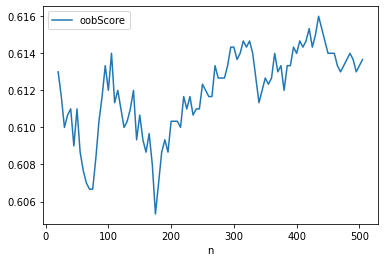

In [27]:
n_estimator = list(range(20, 510, 5))
oobScores = []
for n in n_estimator:
    rf = RandomForestClassifier(n_estimators=n, 
                                criterion='entropy', max_depth=5,
                                random_state=1, oob_score=True)
    rf.fit(X, y)
    oobScores.append(rf.oob_score_)

pd.DataFrame({
    'n': n_estimator, 
    'oobScore': oobScores
}).plot(x='n', y='oobScore')

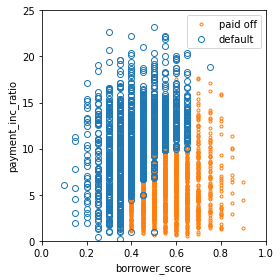

In [28]:
predictions = X.copy()
predictions['prediction'] = rf.predict(X)
predictions.head()

fig, ax = plt.subplots(figsize=(4, 4))

predictions.loc[predictions.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.',
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
predictions.loc[predictions.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o',
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout()
plt.show()

### 6.3.3 변수 중요도
- random forest는 피처와 레코드의 개수가 많은 데이터에 대해 예측 모델을 만들 때 장점을 발휘
- 다수의 예측변수 중 어떤 것이 중요한지, 그리고 그들 사이에 존재하는 상관관계 항들에 대응되는 복합한 관계들을 자동으로 결정하는 능력이 있다.

In [29]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True)
y = loan_data[outcome]

rf_all = RandomForestClassifier(n_estimators=500, random_state=1)
rf_all.fit(X, y)

RandomForestClassifier(n_estimators=500, random_state=1)

importance = True 설정은 randomForest 함수에 다른 변수들의 중요도에 관한 정보를 추가적으로 저장하도록 요청.

In [30]:
importances = rf_all.feature_importances_ ;importances

array([0.08003282, 0.09305178, 0.09940073, 0.10625172, 0.0940495 ,
       0.09745487, 0.01104851, 0.0086448 , 0.0672878 , 0.09668386,
       0.052545  , 0.08765829, 0.02099731, 0.00745048, 0.00751983,
       0.00361399, 0.001342  , 0.00250088, 0.00164589, 0.00142945,
       0.00435205, 0.00325744, 0.00108756, 0.0017619 , 0.00754464,
       0.00392748, 0.00356041, 0.00162601, 0.00483244, 0.00333968,
       0.00759515, 0.01309656, 0.00340917])

In [31]:
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [32]:
rf = RandomForestClassifier(n_estimators=500)
scores = defaultdict(list)
 
# crossvalidate the scores on a number of different random splits of the data
for _ in range(3):
    train_X, valid_X, train_y, valid_y = train_test_split(X, y, 
                                                          test_size=0.3)
    rf.fit(train_X, train_y)
    acc = metrics.accuracy_score(valid_y, rf.predict(valid_X))
    for column in X.columns:
        X_t = valid_X.copy()
        X_t[column] = np.random.permutation(X_t[column].values)
        shuff_acc = metrics.accuracy_score(valid_y, rf.predict(X_t))
        scores[column].append((acc-shuff_acc)/acc)
print('Features sorted by their score:')
print(sorted([(round(np.mean(score), 4), feat) for
              feat, score in scores.items()], reverse=True))

importances = rf_all.feature_importances_


Features sorted by their score:
[(0.0751, 'borrower_score'), (0.0346, 'grade'), (0.0284, 'term_60 months'), (0.0093, 'annual_inc'), (0.0083, 'payment_inc_ratio'), (0.0031, 'purpose_small_business'), (0.0027, 'purpose__small_business'), (0.0023, 'dti'), (0.0011, 'revol_util'), (0.0009, 'purpose__debt_consolidation'), (0.0008, 'revol_bal'), (0.0006, 'purpose__home_improvement'), (0.0003, 'purpose_vacation'), (0.0003, 'emp_length'), (0.0002, 'purpose__medical'), (0.0002, 'emp_len__ > 1 Year'), (0.0, 'purpose_wedding'), (0.0, 'purpose_moving'), (-0.0, 'purpose_major_purchase'), (-0.0, 'purpose_home_improvement'), (-0.0, 'purpose__other'), (-0.0, 'purpose__major_purchase'), (0.0, 'home__OWN'), (-0.0001, 'purpose_other'), (-0.0001, 'purpose_medical'), (-0.0003, 'pub_rec_zero'), (-0.0004, 'purpose_house'), (-0.0005, 'open_acc'), (-0.0007, 'purpose_credit_card'), (-0.0007, 'delinq_2yrs_zero'), (-0.0008, 'home__RENT'), (-0.001, 'loan_amnt'), (-0.0012, 'purpose_debt_consolidation')]


In [33]:
df = pd.DataFrame({
    'feature': X.columns, 
    'Accuracy decrease': [np.mean(scores[column]) for column in 
                         X.columns],
    'Gini decrease': rf_all.feature_importances_, 
    'Entropy decrease': rf_all_entropy.feature_importances_,
})
df = df.sort_values('Accuracy decrease')

fig, axes = plt.subplots(ncols=2, figsize=(8, 5))
ax = df.plot(kind='barh', x='feature', y='Accuracy decrease', 
             legend=False, ax=axes[0])
ax.set_ylabel('')

ax = df.plot(kind='barh', x='feature', y='Gini decrease', 
             legend=False, ax=axes[1])
ax.set_ylabel('')
ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

NameError: name 'rf_all_entropy' is not defined

###### 변수 중요도 측정 방법
1. 변수의 값을 랜덤하게 섞었다면, <b>모델의 정확도가 감소하는 정도</b>를 측정. 결과는 OOB데이터로부터 얻는다(결국 교차타당성검사와 같은 효과를 얻음).
2. 특정 변수를 기준으로 분할이 일어난 모든 노드에서 <b>불순도 점수의 평균 감소량</b> 측정. 학습데이터 기반으로 측정되기 때문에 OOB 데이터를 가지고 계산한 것에 비해 믿을만 하지 않다.

- 정확도 감소량이 더 믿을만한 지표일지라도, 계산 복잡도 측면에서 지니 불순도를 활용한다. 
- 또한, 지니 불순도의 감소를 통해 분할 규칙을 만드는 데 어떤 변수를 사용하는 것이 좋을지를 더욱 분명히 알 수 있다.

### 6.3.4 하이퍼파라미터(hyperparameter)
1. <b>nodesize/min_samples_leaf</b>
 - 말단 노드(나무에서 잎 부분)의 크기
 - R의 디폴트값: 1(분류), 5(회귀)
 - Python의 sklearn: 1(분류, 회귀)
 
 

2. <b>maxnodes/max_leaf_nodes</b>
 - 각 결정트리에서 전체 노드의 최대 개수
 - 기본적으로 제한 없음. 다만, nodesize 제한 설정에 따라 가장 큰 트리가 결정됨
 - Python에서는 최대 단말 노드 수 지정. 두 파라미터 사이는 다음과 같은 관계가 있다.
 
$$maxnodes = 2 * max_leaf_nodes -1$$

- 하이퍼파라미터에 다른 값들을 적용했을 때의 효과를 알아보려면 교차타당성검사를 이용할 수 있음

###### 주요 개념
- 앙상블 모델은 많은 모델로부터 얻은 결과를 서로 결합해 모델 정확도를 높인다.
- 배깅은 앙상블 모델 가운데 하나의 형태로, 부트스트랩 샘플을 이용해 많은 모델들을 생성하고 이 모델들을 평균화한다.
- 랜덤 포레스트는 배깅 기법을 의사 결정 트리 알고리즘에 적용한 특별한 형태이다. 랜덤 포레스트에서는 데이터를 재표본추출하는 동시에 트리를 분할할 때 예측변수 또한 샘플링한다.
- 랜덤 포레스트로부터 나오는 출력 중 유용한 것은 예측변수들이 모델 정확도에 미치는 영향력을 의미하는 변수 중요도 이다.
- 랜덤 포레스트에서는 오버피팅을 피하기 위해 교차타당성검사를 통해 조정된 하이퍼파라미터를 사용한다.

## 6.4 부스팅

*참고 : https://www.youtube.com/watch?v=GciPwN2cde4

- 앙상블기법의 하나로 이전 모델이 갖는 오차를 줄이는 방향으로 다음 모델을 연속적으로 생성
- <b>Adaboost, Gradient Boosting Model(GBM), 확률적 그래디언트 부스팅</b>은 가장 자주 사용되는 변형된 형태의 부스팅 알고리즘
- 그 중, 확률적 그래디언트 부스팅이 가장 널리 사용됨

=====================================================================================================================
###### 용어정리
- 앙상블(ensemble): 여러 모델들의 집합을 통해 예측 결과를 만들어내는 것(유의어: 모델 평균화)
- 부스팅(boosting): 연속된 라운드마다 잔차가 큰 레코드들에 가중치를 높여 일련의 모델들을 생성하는 일반 기법
- 에이다부스트(Adaboost): 잔차에 따라 데이터의 가중치를 조절하는 부스팅의 초기 버전
- 그래디언트 부스팅(Gradient boosting): 비용함수(cost function)를 최소화하는 방향으로 부스팅을 활용하는 좀 더 일반적 형태
- 확률적 그래디언트 부스팅(stochastic gradient boosting): 각 라운드마다 레코드와 열을 재표본추출하는 것을 포함하는 부스팅의 가장 일반적 형태
- Regularization: 비용함수에 모델의 파라미터 개수에 해당하는 벌점 항을 추가해 오버피팅을 피하는 방법
- 하이퍼파라미터(hyperparameter): 알고리즘을 피팅하기 전에 미리 세팅해야 하는 파라미터

=====================================================================================================================

### 6.4.1 부스팅 알고리즘

###### Adaboost Algorithm (ver YOUTUBE class)
 1. Set $W_i=\frac {1} {n}, i=1, 2, ..., n $ (impose equal weight initally)
 2. for $j=1$ to $m$ ($m$: number of classifiers)
  (a) Find $h_j(x)$ that minimize $L_j$ (weighted loss function)
$$L_j = \frac {\sum_{i=1}^n{W_iI(y_i\neq h_j(x)}} {\sum_{i=1}^n {W_i}} $$
  (b) Define the weight of a classifier: $\alpha_j = \log{\frac{1-L_j}{L_j}}$
  (c) Update Weight: $W_i = W_ie^{\alpha_jI(y_i\neq h_j(x))}$
 3. Final Boosted Model: $h(x) = sign[\sum_{i=1}^m{\alpha_j h_j(x)}]$
 
###### Adaboost Algorithm (ver book)
1. 
 (1) 피팅할 모델의 수 $M$ 설정 <br>
 (2) 반복 횟수를 의미하는 $m=1$로 초기화 <br>
 (3) 관측 가중치 $W_i=\frac {1} {n}, i=1, 2, ..., n $로 초기화 <br>
 (4) 앙상블 모델을 $\hat{F}_0 = 0$으로 초기화 <br>
2. 관측 가중치 $w_1, w_2, ..., w_N$을 이용해 모델 $\hat{f}_m$학습. 이때 가중 오차 $e_m$이 최소화되도록 학습 <br>
  ($e_m$: 잘못 분류된 관측치에 대해 가중치를 적용한 합을 의미) <br>
3. 앙상블 모델에 다음 모델 추가 <br>
  $\hat{F}_m = \hat{F}_{m-1}+\alpha_m\hat{f}_m$, ($\alpha_m = \frac{\log{1-e_m}} {e_m}$)
4. 잘못 분류된 입력에 대한 가중치를 증가하는 방향으로 $w_1, w_2, ..., w_N$을 업데이트
5. 모델 반복 횟수를 $m=m+1$으로 증가시키고, $m<M$이면 다시 2단계로 돌아간다
6. 이 과정을 통해 얻은 부스팅 추정치: $\hat{F} = \alpha_1\hat{f}_1 + \alpha_2\hat{f}_2 + ... + \alpha_M\hat{f}_M$

###### Gradient Boosting Model(GBM) Algorithm
- Adaboosting과 거의 비슷하지만, 비용함수를 최적화하는 접근법 사용
- 가중치 조정 대신 모델이 pseudo-residual(유사잔차)을 학습하도록 함

1. Initialize $f_0(x) = arg\min_\gamma\sum_{i=1}^{N}L(y_i, \gamma)$
2. for $m=1$ to $m=M$: <br>
 (a) For $i=1,2,...,N$ compute:  <br>
    $$\gamma_{im} = - [\frac{\delta L(y_i, f(x_i))}{\delta f(x_i)}]_{f=f_{m-1}}$$
 (b) Fit a regression tree to the targets $\gamma_{im}$ giving terminal regions $R_{jm}, j=1,2,...,J_m$
 (c) For $j=1,2,...,J_m$ compute:
 $$\gamma_{jm} = arg\min_r\sum_{x_i in R_{jm}}L(y_i, f_{m-1}(x_i)+\gamma)$$
 (d) Update $f_m(x) = f_{m-1}(x) + \sum_{j=1}^{J_m}{\gamma_{jm}I(x in R_{jm})}$
3. Output $\hat{f}(x) = f_M(x)$.

### 6.4.2 XGBoost
 - 확률적 그래디언트 부스팅
 - XGBoost의 중요한 파라미터 <br>
  (1) subsample: 각 반복 구간마다 샘플링할 입력 데이터의 비율 조정 <br>
  (2) eta(learning_rate): 부스팅 알고리즘에서 $\alpha_m$에 적용되는 축소 비율로 가중치의 변화량을 낮추어 오버피팅 방지 효과가 있음 <br>
  

In [34]:
from xgboost import XGBClassifier

In [ ]:
#pip install xgboost

In [35]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = pd.Series([1 if o == 'default' else 0 for o in loan3000[outcome]])

xgb = XGBClassifier(objective='binary:logistic', subsample=.63, 
                    use_label_encoder=False, eval_metric='error')
print(xgb.fit(X, y))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.63,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)


In [36]:
xgb_df = X.copy()
xgb_df['prediction'] = ['default' if p == 1 else 'paid off' for p in xgb.predict(X)]
xgb_df['prob_default'] = xgb.predict_proba(X)[:, 0]
print(xgb_df.head())

   borrower_score  payment_inc_ratio prediction  prob_default
0            0.40            5.11135   paid off      0.828856
1            0.40            5.43165    default      0.260156
2            0.70            9.23003    default      0.320805
3            0.40            2.33482   paid off      0.678005
4            0.45           12.10320    default      0.140204


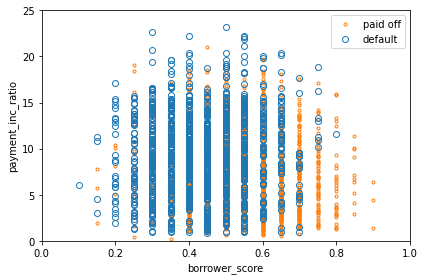

In [37]:
fig, ax = plt.subplots(figsize=(6, 4))

xgb_df.loc[xgb_df.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
xgb_df.loc[xgb_df.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o', 
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout()
plt.show()

### 6.4.3 Regularization: 오버피팅 피하기
- 오버피팅이 일으키는 문제
 - 학습데이터에 없는 새로운 데이터에 대한 모델 정확도가 떨어진다.
 - 모델의 예측 결과에 변동이 심하고 불안정한 결과를 보인다.
 
###### Regularization
 - 모델의 복잡도에 따라 벌점을 추가하는 형태로 비용함수를 변경하는 방법
 - XGboost에는 모델을 Regularization하기위한 두 파라미터 alpha(맨해튼거리, L1-regularzattion)와 lambda(유클리드 거리, L2-regularization가 있다.
 - 위 파라미터를 크게 설정하면 모델이 복잡해질수록 더 많은 벌점을 부여하고 결과적으로 얻는 트리의 크기가 작아진다.

In [38]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True)
y = pd.Series([1 if o == 'default' else 0 for o in loan_data[outcome]])

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=10000)

xgb_default = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                            reg_lambda=0, learning_rate=0.3, subsample=1,
                            use_label_encoder=False, eval_metric='error')
xgb_default.fit(train_X, train_y)

xgb_penalty = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                            reg_lambda=1000, learning_rate=0.1, subsample=0.63,
                            use_label_encoder=False, eval_metric='error')
print(xgb_penalty.fit(train_X, train_y))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=250, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1000, scale_pos_weight=1, subsample=0.63,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)


In [39]:
pred_default = xgb_default.predict_proba(train_X)[:, 1]
error_default = abs(train_y - pred_default) > 0.5
print('default (train): ', np.mean(error_default))

default (train):  0.11971591873691359


In [40]:
pred_default = xgb_default.predict_proba(valid_X)[:, 1]
error_default = abs(valid_y - pred_default) > 0.5
print('default: ', np.mean(error_default))


default:  0.351


In [41]:
pred_penalty = xgb_penalty.predict_proba(valid_X)[:, 1]
error_penalty = abs(valid_y - pred_penalty) > 0.5
print('penalty: ', np.mean(error_penalty))

penalty:  0.3268


In [42]:
results = []
for ntree_limit in range(1, 250):
    train_default = xgb_default.predict_proba(train_X, ntree_limit=ntree_limit)[:, 1]
    train_penalty = xgb_penalty.predict_proba(train_X, ntree_limit=ntree_limit)[:, 1]
    pred_default = xgb_default.predict_proba(valid_X, ntree_limit=ntree_limit)[:, 1]
    pred_penalty = xgb_penalty.predict_proba(valid_X, ntree_limit=ntree_limit)[:, 1]
    results.append({
        'iterations': ntree_limit,
        'default train': np.mean(abs(train_y - train_default) > 0.5),
        'penalty train': np.mean(abs(train_y - train_penalty) > 0.5),
        'default test': np.mean(abs(valid_y - pred_default) > 0.5),
        'penalty test': np.mean(abs(valid_y - pred_penalty) > 0.5),
    })

results = pd.DataFrame(results)
print(results.head())

C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  w

C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  w

C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  w

C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  w

C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\minjw\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  w

   iterations  default train  penalty train  default test  penalty test
0           1       0.341888       0.335182        0.3416        0.3445
1           2       0.330881       0.335239        0.3371        0.3412
2           3       0.328759       0.340699        0.3355        0.3455
3           4       0.325420       0.338747        0.3324        0.3413
4           5       0.321402       0.340784        0.3330        0.3417


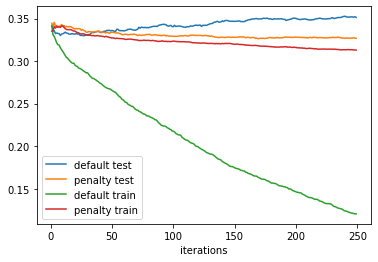

In [43]:
ax = results.plot(x='iterations', y='default test')
results.plot(x='iterations', y='penalty test', ax=ax)
results.plot(x='iterations', y='default train', ax=ax)
results.plot(x='iterations', y='penalty train', ax=ax)
plt.show()

###### 능형회귀(Ridge Regression)과  Lasso Regression
 - <b>Ridge Regression</b>: 
 $$\sum_{i=1}^n(Y_i-\hat{b}_0 - \hat{b}_1X_i - \hat{b}X_p)^2 + \lambda(\hat{b}_1^2 + ... + \hat{b}_p^2)$$
  - 잔차제곱합에 회귀계수의 개수와 크기에 대한 함수인 벌점을 추가한 값을 최소화한다.
  - 유클리드 거리 활용
  - $\lambda$는 계수에 대해 어느 정도 벌점을 부여할 것인가를 결정

<br>

 - <b>Lasso Regression</b>:
 $$\sum_{i=1}^n(Y_i-\hat{b}_0 - \hat{b}_1X_i - \hat{b}X_p)^2 + \alpha(|b_1| + ... + |b_p|)$$
   - 릿지와 유사하되, 벌점 항에 유클리드 거리 대신 맨해튼 거리 이용
  
<br>

- 유클리드 거리를 사용하는 것은 L2-Regularization이라고하며, 맨해튼 거리를 사용하는 것은 L1-Regularization이라고 함

### 6.4.4 하이퍼파라미터와 교차타당성 검사
 - 파라미터 선정을 위해 교차타당성 검사 활용

In [45]:
from itertools import product

In [46]:
idx = np.random.choice(range(5), size=len(X), replace=True)
error = []
for eta, max_depth in product([0.1, 0.5, 0.9], [3, 6, 9]):
    xgb = XGBClassifier(objective='binary:logistic', n_estimators=250, 
                        max_depth=max_depth, learning_rate=eta,
                        use_label_encoder=False, eval_metric='error')
    cv_error = []
    for k in range(5):
        fold_idx = idx == k
        train_X = X.loc[~fold_idx]; train_y = y[~fold_idx]
        valid_X = X.loc[fold_idx]; valid_y = y[fold_idx]

        xgb.fit(train_X, train_y)
        pred = xgb.predict_proba(valid_X)[:, 1]
        cv_error.append(np.mean(abs(valid_y - pred) > 0.5))
    error.append({
        'eta': eta,
        'max_depth': max_depth,
        'avg_error': np.mean(cv_error)
    })
    print(error[-1])
errors = pd.DataFrame(error)
print(errors)

{'eta': 0.1, 'max_depth': 3, 'avg_error': 0.32873372957256286}
{'eta': 0.1, 'max_depth': 6, 'avg_error': 0.3331213363166813}
{'eta': 0.1, 'max_depth': 9, 'avg_error': 0.34540519836160133}
{'eta': 0.5, 'max_depth': 3, 'avg_error': 0.3398996929080499}
{'eta': 0.5, 'max_depth': 6, 'avg_error': 0.36822811252942333}
{'eta': 0.5, 'max_depth': 9, 'avg_error': 0.37410665093702067}
{'eta': 0.9, 'max_depth': 3, 'avg_error': 0.35526446623061947}
{'eta': 0.9, 'max_depth': 6, 'avg_error': 0.38944088033701174}
{'eta': 0.9, 'max_depth': 9, 'avg_error': 0.383103696250202}
   eta  max_depth  avg_error
0  0.1          3   0.328734
1  0.1          6   0.333121
2  0.1          9   0.345405
3  0.5          3   0.339900
4  0.5          6   0.368228
5  0.5          9   0.374107
6  0.9          3   0.355264
7  0.9          6   0.389441
8  0.9          9   0.383104


###### XGBoost's Hyperparameter
- 오버피팅, 정확도, 계산복잡도 사이의 균형을 잡기 위해 사용됨

- 주요 파라미터
 - <b>eta/learning_rate</b>: 부스팅 알고리즘에서 $\alpha$에 적용되는 0과 1사이의 축소인자. 기본값은 0.35이지만, 노이즈가 있는 데이터에서는 더 작은 값을 추천(파이썬에서는 0.1이 기본값)
 - <b>rnounds/n_estimators</b>: 부스팅 라운드 횟수. eta가 작은 값이라면 알고리즘의 학습 속도가 늦춰지기 때문에 라운드 횟수를 늘려야 한다. 오버피팅을 방지하는 파라미터 설정이 포함된 경우, 라운드 횟수를 좀 더 늘려도 괜찮다.
 - <b>max_depth</b>: 트리의 최대 깊이. 깊이가 아주 깊은 트리를 만드는 RF와 달리 부스팅 트리는 깊이가 얕다. 이는 노이즈가 많은 데이터에 대해 모델이 복잡한 거짓 상호작용을 회피하는데 도움이 된다.
 - <b>subsample 및 colsample_bytree</b>: 전체 데이터에서 일부 데이터를 비복원 샘플링하는 비율 및 예측변수 중 일부 변수를 샘플링하는 비율. 이는 랜덤 포레스트에서 오버피팅을 피하기 위해 사용했던 것들과 유사하다.
 - <b>lambda/reg_lambda 및 alpha/reg_alpha</b>: 오버피팅을 조절하기 위해 사용되는 regularization 파라미터들

###### 주요개념
 - 부스팅 방법은 일련의 모델들을 피팅할 때 이전 라운드에서 오차가 컸던 레코드들에 가중치를 더하는 방식을 사용하는 앙상블 모델의 한 부류이다.
 - 확률적 그래디언트 부스팅은 부스팅 가운데 가장 일반적으로 사용되며 가장 좋은 성능을 보인다. 확률적 그래디언트 부스팅의 가장 일반적 형태는 트리 모델을 사용한다.
 - XGBoost는 확률적 그래디언트 부스팅을 사용하기 위한 가장 유명한 소프트웨어 패키지이다. 데이터 과학에서 활용되는 거의 대부분의 언어를 지원한다.
 - 부스팅은 데이터에 오버피팅되기 쉽다.이를 피하기 위해 하이퍼파라미터를 잘 설정해야 한다.
 - Regularization은 파라미터 개수(예를 들어 트리 크기)에 관한 벌점 항목을 모델링에 포함하여 오버피팅을 피하는 방법
 - 부스팅에서 여러 개의 하이퍼파라미터들의 조합을 찾아야 할 때, 교차타당성검사는 아주 중요하다.